In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer

from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

/Users/shin/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#データの読み込み
item_categories = pd.read_csv("item_categories.csv")
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")
sales_train = pd.read_csv("sales_train.csv")

In [3]:
# データを結合
train = sales_train.merge(items,how="left").merge(item_categories,how="left").merge(shops,how="left")
test = test.merge(items,how="left").drop("item_name",axis=1)

In [4]:
# testに含まれるデータを抽出する
test_shop_id = test["shop_id"].unique()
test_item_id = test["item_id"].unique()

# trainの中からtestにあるデータを抜き出す
train_lk = train[train["shop_id"].isin(test_shop_id)]
train_lk = train_lk[train_lk["item_id"].isin(test_item_id)]

In [5]:
# 月次のデータに変換する
train_monthly = train_lk.sort_values("date_block_num").groupby(
            ["shop_id","item_id","date_block_num","item_category_id"],as_index=False).agg(
                {"item_price":["sum","last","mean"],"item_cnt_day":["sum","mean","count"]})

In [6]:
train_monthly.columns = [
                "shop_id",
                "item_id",
                'date_block_num',
                'item_category_id',
                "item_price",
                'last_item_price', 
                'mean_item_price', 
                'sum_item_cnt', 
                'mean_item_cnt', 
                'count_item_cnt']

In [7]:
# 月×店舗×商品のテーブルを作成
train_shop_id = train_monthly["shop_id"].unique()
train_item_id =train_monthly["item_id"].unique()

df = []

for month in range(34):
    for shop in train_shop_id:
        for item in train_item_id:
            df.append([month,shop,item])
            
df= pd.DataFrame(df,columns=["date_block_num","shop_id","item_id"])
df.head()

,date_block_num,shop_id,item_id
0,0,2,30
1,0,2,31
2,0,2,32
3,0,2,33
4,0,2,53


In [8]:
#trainデータとマージしてNAはゼロで補完する
train_monthly = pd.merge(df,train_monthly,on=["date_block_num","item_id","shop_id"],how="left")

In [9]:
train_monthly.fillna(0,inplace=True)

In [10]:
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

Text(0, 0.5, 'item_cnt_day')

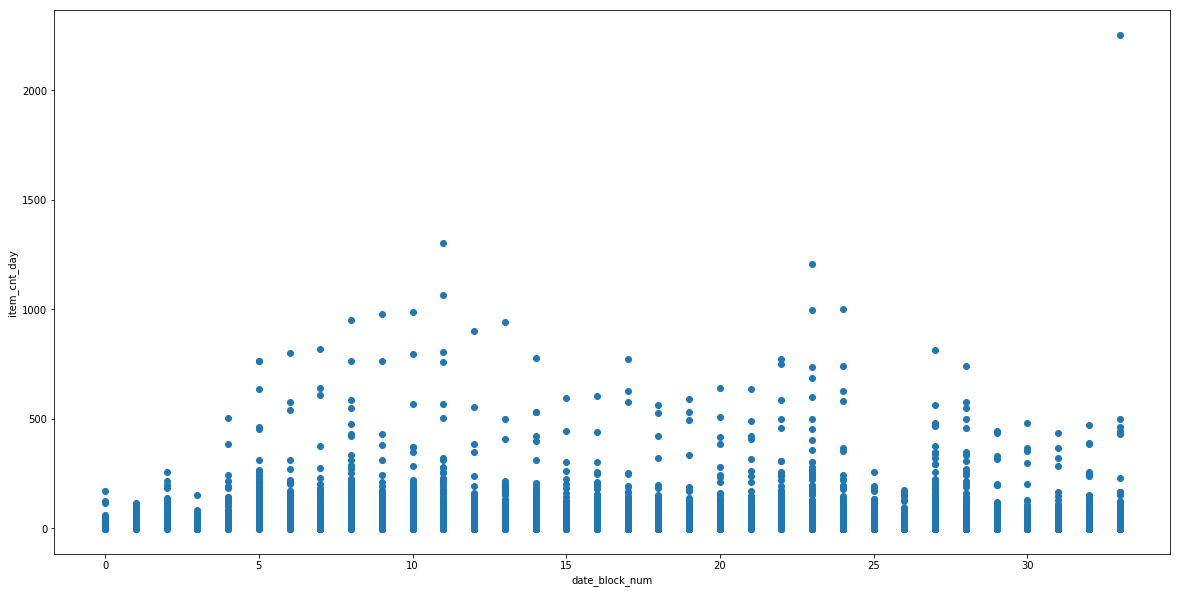

In [ ]:
#時系列の売上個数をカウント
plt.figure(figsize=(20, 10))
plt.scatter(train_monthly["date_block_num"],train_monthly["sum_item_cnt"])
plt.xlabel("date_block_num")
plt.ylabel("item_cnt_day")

In [11]:
#外れ値を除外
temp = train_monthly.sort_values(by="sum_item_cnt").reset_index(drop=True)

#0.1%タイルの位置
q001 = round(len(temp)*0.001)

#99.9%タイルの位置
q999 = round(len(temp)*0.999)

#上下0.5%を除いて抽出
train_monthly_leave_outlier = temp.iloc[q001:q999,:]

Text(0, 0.5, 'item_cnt_day')

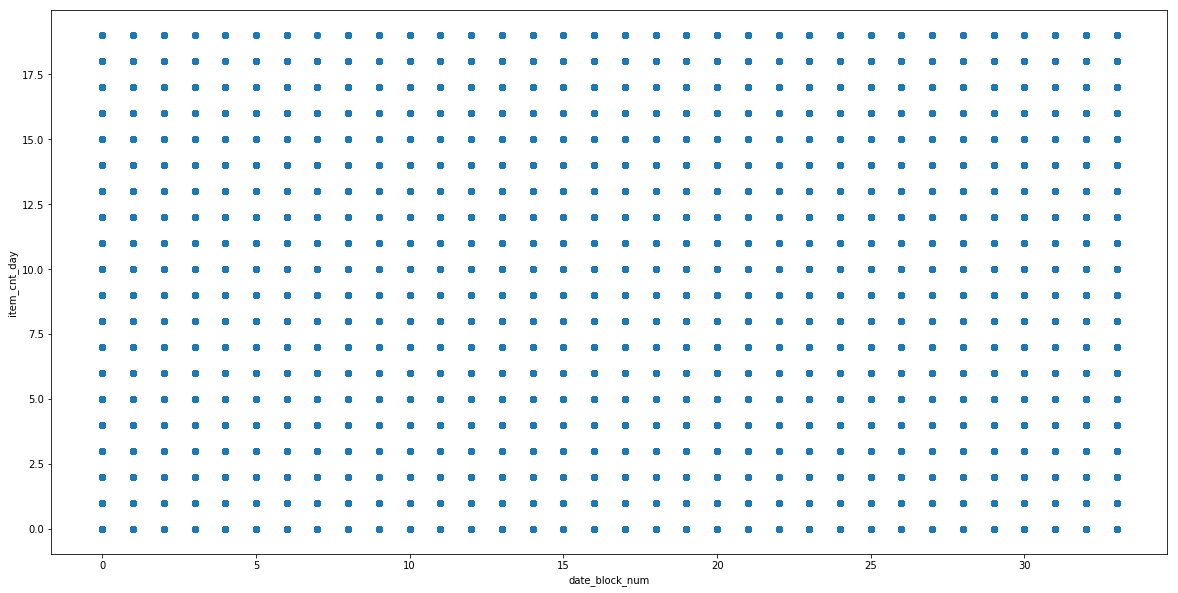

In [12]:
#時系列の売上個数をカウント
plt.figure(figsize=(20, 10))
plt.scatter(train_monthly_leave_outlier["date_block_num"],train_monthly_leave_outlier["sum_item_cnt"])
plt.xlabel("date_block_num")
plt.ylabel("item_cnt_day")

## 特徴量エンジニアリング

In [13]:
# ３ヶ月の移動平均を追加
train_monthly_leave_outlier["average_3month"] = train_monthly_leave_outlier.groupby(
                                                                            ['shop_id', 'item_id'])['sum_item_cnt'].apply(
                                                                                    lambda x: x.rolling(window=3,min_periods=1).mean().shift())

/Users/shin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [14]:
#商品1つあたりの平均価格を追加
train_monthly_leave_outlier['item_price_unit'] = train_monthly_leave_outlier['item_price'] // train_monthly_leave_outlier['count_item_cnt']
train_monthly_leave_outlier['item_price_unit'].fillna(0, inplace=True)

/Users/shin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/shin/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [15]:
#max価格とmin価格を追加
gp_item_price = train_monthly_leave_outlier.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly_leave_outlier = pd.merge(train_monthly_leave_outlier, gp_item_price, on='item_id', how='left')

In [26]:
#価格の変動量を追加
train_monthly_leave_outlier['price_increase'] = train_monthly_leave_outlier['item_price'] - train_monthly_leave_outlier['hist_min_item_price']
train_monthly_leave_outlier['price_decrease'] = train_monthly_leave_outlier['hist_max_item_price'] - train_monthly_leave_outlier['item_price']

## validation

In [40]:
# validationの設定

#単純にhold-outで最後の１ヶ月分をvalidとする
train_monthly_leave_outlier = train_monthly_leave_outlier.sort_values(by="date_block_num").reset_index(drop=True)

valid = train_monthly_leave_outlier[train_monthly_leave_outlier["date_block_num"]==32]
train = train_monthly_leave_outlier[train_monthly_leave_outlier["date_block_num"] < 31]
test_test = train_monthly_leave_outlier[train_monthly_leave_outlier["date_block_num"] == 33]

#29~33をvalid、3~28をtrainとする。最初の3ヶ月は移動平均がないので除外する
#train_monthly_leave_outlier = train_monthly_leave_outlier.sort_values(by="date_block_num").reset_index(drop=True)

# valid = train_monthly_leave_outlier[train_monthly_leave_outlier["date_block_num"] > 28]
# train = train_monthly_leave_outlier[train_monthly_leave_outlier["date_block_num"] < 29]

# xとyに分割する
#train_x = train.drop(["sum_item_cnt","date_block_num"], axis=1)
train_x = train.drop(["sum_item_cnt"], axis=1)
train_y = train["sum_item_cnt"]
#valid_x = valid.drop(["sum_item_cnt","date_block_num"], axis=1)
valid_x = valid.drop(["sum_item_cnt"], axis=1)
valid_y = valid["sum_item_cnt"]

test_test_x = test_test.drop(["sum_item_cnt"], axis=1)
test_test_y = test_test["sum_item_cnt"]

In [23]:
# testデータに特徴量を追加
test_v2 = pd.merge(test, train_monthly_leave_outlier, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
test_v2['year'] = 2015
test_v2['month'] = 9
test_v2.drop(['sum_item_cnt'], axis=1, inplace=True)
#test_v2[int_features] = test_v2[int_features].astype('int32')
test_v2 = test_v2[train_x.columns]

## mean encoding

## モデリング

### lightGBM

In [41]:
#データセットを生成する
lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(valid_x, valid_y, reference=lgb_train)

#LightGBM のハイパーパラメータ
lgb_params = {
        'objective': 'regression',
        'num_leaves': 10,
        'learning_rate': 0.1, 
        'n_estimators': 1000,
        'max_bin': 255, 
        'bagging_fraction': 0.75,
        'bagging_freq': 5, 
        'bagging_seed': 7,
        'feature_fraction': 0.2,
        'feature_fraction_seed': 7,
        'verbose': -1,
        'metric': 'rmse'
    }

lgb_evals_result = {}

# 上記のパラメータでモデルを学習する
lightgbm = lgb.train(
                    lgb_params, 
                    lgb_train, 
                    valid_sets=lgb_eval,
                    evals_result=lgb_evals_result,
                )

ypred = lightgbm.predict(train_x)

/Users/shin/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 0.862362
[2]	valid_0's rmse: 0.814737
[3]	valid_0's rmse: 0.773663
[4]	valid_0's rmse: 0.744813
[5]	valid_0's rmse: 0.694622
[6]	valid_0's rmse: 0.639492
[7]	valid_0's rmse: 0.592374
[8]	valid_0's rmse: 0.566751
[9]	valid_0's rmse: 0.554164
[10]	valid_0's rmse: 0.540342
[11]	valid_0's rmse: 0.503178
[12]	valid_0's rmse: 0.470656
[13]	valid_0's rmse: 0.461481
[14]	valid_0's rmse: 0.454092
[15]	valid_0's rmse: 0.449432
[16]	valid_0's rmse: 0.42279
[17]	valid_0's rmse: 0.398836
[18]	valid_0's rmse: 0.386735
[19]	valid_0's rmse: 0.383471
[20]	valid_0's rmse: 0.381251
[21]	valid_0's rmse: 0.368559
[22]	valid_0's rmse: 0.34846
[23]	valid_0's rmse: 0.332629
[24]	valid_0's rmse: 0.329731
[25]	valid_0's rmse: 0.328243
[26]	valid_0's rmse: 0.32691
[27]	valid_0's rmse: 0.312047
[28]	valid_0's rmse: 0.29975
[29]	valid_0's rmse: 0.298551
[30]	valid_0's rmse: 0.297948
[31]	valid_0's rmse: 0.297628
[32]	valid_0's rmse: 0.285006
[33]	valid_0's rmse: 0.275202
[34]	valid_0's rmse: 0.

[270]	valid_0's rmse: 0.106837
[271]	valid_0's rmse: 0.106822
[272]	valid_0's rmse: 0.10565
[273]	valid_0's rmse: 0.105553
[274]	valid_0's rmse: 0.105541
[275]	valid_0's rmse: 0.105527
[276]	valid_0's rmse: 0.105512
[277]	valid_0's rmse: 0.105707
[278]	valid_0's rmse: 0.105496
[279]	valid_0's rmse: 0.105289
[280]	valid_0's rmse: 0.105277
[281]	valid_0's rmse: 0.105251
[282]	valid_0's rmse: 0.105243
[283]	valid_0's rmse: 0.105101
[284]	valid_0's rmse: 0.104835
[285]	valid_0's rmse: 0.104794
[286]	valid_0's rmse: 0.104792
[287]	valid_0's rmse: 0.104784
[288]	valid_0's rmse: 0.104247
[289]	valid_0's rmse: 0.104165
[290]	valid_0's rmse: 0.104147
[291]	valid_0's rmse: 0.104156
[292]	valid_0's rmse: 0.104156
[293]	valid_0's rmse: 0.104083
[294]	valid_0's rmse: 0.103777
[295]	valid_0's rmse: 0.103493
[296]	valid_0's rmse: 0.103495
[297]	valid_0's rmse: 0.103456
[298]	valid_0's rmse: 0.103443
[299]	valid_0's rmse: 0.103283
[300]	valid_0's rmse: 0.103059
[301]	valid_0's rmse: 0.103043
[302]	val

[531]	valid_0's rmse: 0.0869782
[532]	valid_0's rmse: 0.0869749
[533]	valid_0's rmse: 0.0869591
[534]	valid_0's rmse: 0.0869574
[535]	valid_0's rmse: 0.0868825
[536]	valid_0's rmse: 0.0868887
[537]	valid_0's rmse: 0.0868898
[538]	valid_0's rmse: 0.0868914
[539]	valid_0's rmse: 0.0868963
[540]	valid_0's rmse: 0.0869085
[541]	valid_0's rmse: 0.0869184
[542]	valid_0's rmse: 0.0869133
[543]	valid_0's rmse: 0.086907
[544]	valid_0's rmse: 0.0864251
[545]	valid_0's rmse: 0.0863899
[546]	valid_0's rmse: 0.0863911
[547]	valid_0's rmse: 0.086402
[548]	valid_0's rmse: 0.0864017
[549]	valid_0's rmse: 0.0863669
[550]	valid_0's rmse: 0.0863383
[551]	valid_0's rmse: 0.0863255
[552]	valid_0's rmse: 0.086309
[553]	valid_0's rmse: 0.0862905
[554]	valid_0's rmse: 0.0862711
[555]	valid_0's rmse: 0.0862578
[556]	valid_0's rmse: 0.0862418
[557]	valid_0's rmse: 0.0862475
[558]	valid_0's rmse: 0.0862426
[559]	valid_0's rmse: 0.0862412
[560]	valid_0's rmse: 0.0855812
[561]	valid_0's rmse: 0.0855379
[562]	valid

[788]	valid_0's rmse: 0.0761043
[789]	valid_0's rmse: 0.0760852
[790]	valid_0's rmse: 0.0760512
[791]	valid_0's rmse: 0.0760359
[792]	valid_0's rmse: 0.0760355
[793]	valid_0's rmse: 0.0760312
[794]	valid_0's rmse: 0.0760255
[795]	valid_0's rmse: 0.0759596
[796]	valid_0's rmse: 0.0759379
[797]	valid_0's rmse: 0.0759364
[798]	valid_0's rmse: 0.0759405
[799]	valid_0's rmse: 0.0759404
[800]	valid_0's rmse: 0.0755855
[801]	valid_0's rmse: 0.0755711
[802]	valid_0's rmse: 0.0755603
[803]	valid_0's rmse: 0.0755606
[804]	valid_0's rmse: 0.0755589
[805]	valid_0's rmse: 0.0755416
[806]	valid_0's rmse: 0.0751818
[807]	valid_0's rmse: 0.0751558
[808]	valid_0's rmse: 0.0751328
[809]	valid_0's rmse: 0.0751264
[810]	valid_0's rmse: 0.075123
[811]	valid_0's rmse: 0.0750989
[812]	valid_0's rmse: 0.0750833
[813]	valid_0's rmse: 0.0750781
[814]	valid_0's rmse: 0.0750691
[815]	valid_0's rmse: 0.0750719
[816]	valid_0's rmse: 0.0748737
[817]	valid_0's rmse: 0.0748476
[818]	valid_0's rmse: 0.0748499
[819]	val

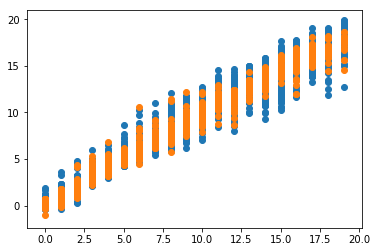

In [43]:
#trainデータとの合致度を可視化
plt.subplots_adjust(wspace=0.4)
plt.scatter(train_y,lightgbm.predict(train_x))
plt.scatter(valid_y,lightgbm.predict(valid_x))

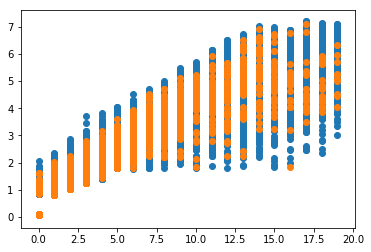

In [200]:
#trainデータとの合致度を可視化
plt.subplots_adjust(wspace=0.4)
plt.scatter(train_y,lightgbm.predict(train_x))
plt.scatter(valid_y,lightgbm.predict(valid_x))

### XGBoost

In [32]:
#特徴量と目的変数をxgboostのデータ構造に変換する
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x,label=valid_y)

/Users/shin/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/shin/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [33]:
#パラメータを指定してGBDT
num_round = 100
evallist = [(dvalid, 'eval'), (dtrain, 'train')]

evals_result = {}

#パラメータ
param = {
            'max_depth': 5,
            'eta': 0.1,
            'objective': 'reg:squarederror',
}

#学習の実行
bst = xgb.train(
                        param, dtrain,
                        num_round,
                        evallist,
                        evals_result=evals_result,
                        # 一定ラウンド回しても改善が見込めない場合は学習を打ち切る
                        early_stopping_rounds=100
                        )

[20:57:03] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	eval-rmse:0.880263	train-rmse:0.845688
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 100 rounds.
[1]	eval-rmse:0.795941	train-rmse:0.769232
[2]	eval-rmse:0.720297	train-rmse:0.689048
[3]	eval-rmse:0.652912	train-rmse:0.622655
[4]	eval-rmse:0.592117	train-rmse:0.566436
[5]	eval-rmse:0.538184	train-rmse:0.509282
[6]	eval-rmse:0.489441	train-rmse:0.464799
[7]	eval-rmse:0.446257	train-rmse:0.417443
[8]	eval-rmse:0.407368	train-rmse:0.377192
[9]	eval-rmse:0.373196	train-rmse:0.345651
[10]	eval-rmse:0.342416	train-rmse:0.314004
[11]	eval-rmse:0.315376	train-rmse:0.286674
[12]	eval-rmse:0.291617	train-rmse:0.259851
[13]	eval-rmse:0.270461	train-rmse:0.238505
[14]	eval-rmse:0.252538	train-rmse:0.218606
[

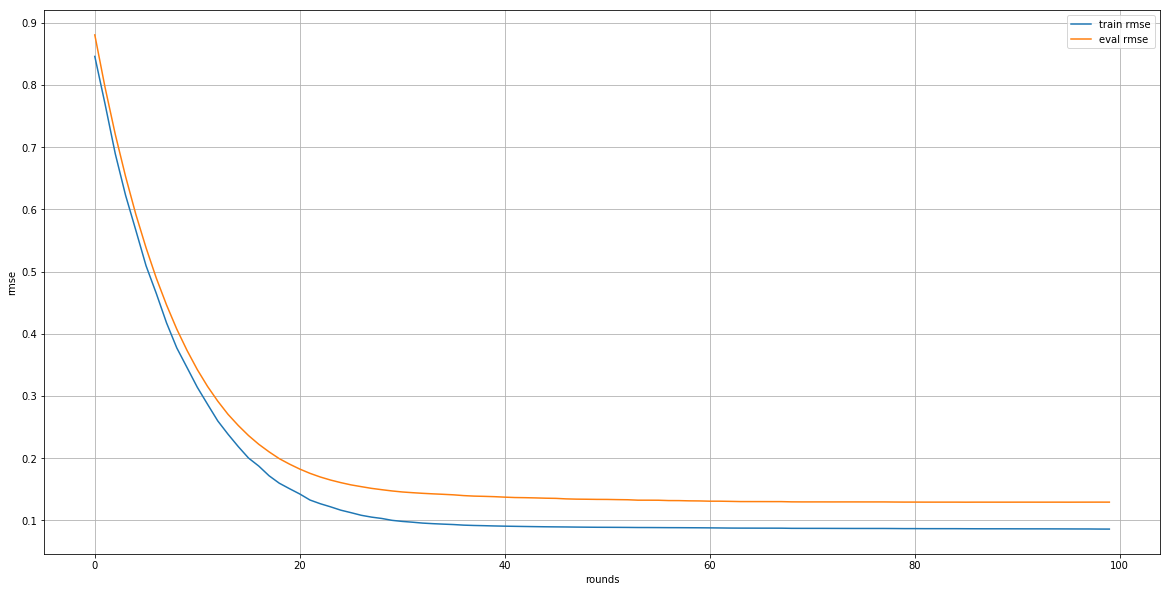

In [39]:
#学習曲線を可視化する
plt.figure(figsize=(20, 10))
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

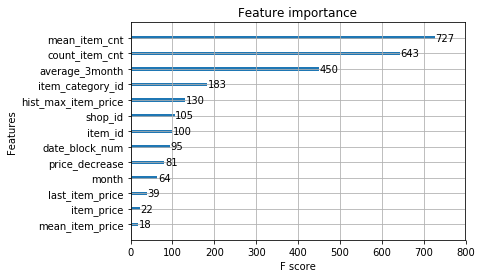

In [34]:
#特徴量ごとの重要度を可視化する
ax = xgb.plot_importance(bst)
fig = ax.figure

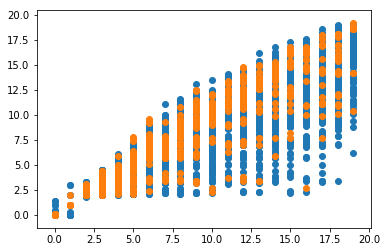

In [38]:
#trainデータとの合致度を可視化
plt.subplots_adjust(wspace=0.4)
plt.scatter(train_y,bst.predict(dtrain))
plt.scatter(valid_y,bst.predict(dvalid))

#### 予備テスト

In [42]:
from sklearn.metrics import mean_squared_error
test_test_pred = lightgbm.predict(test_test_x)
print(np.sqrt(mean_squared_error(test_test_y, test_test_pred)))

0.06436450475383833


## 提出用ファイルの作成

In [24]:
#testデータで実行
lightgbm.predict(test_v2)

array([0.31570408, 0.31570408, 0.31570408, ..., 0.26506671, 0.26506671,
       0.26506671])

In [25]:
# 提出用ファイルの作成
my_submission = pd.DataFrame()
my_submission["Id"] = test["ID"]
my_submission["item_cnt_month"] =lightgbm.predict(test)

# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)

In [21]:
my_submission

,Id,item_cnt_month
0,0,0.300522
1,1,0.243243
2,2,0.300522
3,3,0.293864
4,4,0.300522
5,5,0.293864
6,6,0.300522
7,7,0.243243
8,8,0.243243
9,9,0.300522
